# Загрузка датасета и архитектура модели

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pickle
from IPython.display import display, clear_output
import cv2
import os
import numpy as np


In [2]:
with open('dataset.pickle', 'rb') as file:
    data = pickle.load(file)

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(3, 128, kernel_size=3, padding=1, stride=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1, stride=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 3, kernel_size=3, padding=1, stride=1),
            nn.LeakyReLU(0.2)
        )
    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, stride=1), 
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1), 
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1), 
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(128, 1024, kernel_size=1),  
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1, kernel_size=1)  
        )
    
    def forward(self, x):
        return torch.sigmoid(self.model(x))

dataloader = torch.utils.data.DataLoader(dataset=data)

generator = Generator()
discriminator = Discriminator()
generator.load_state_dict(torch.load('generator.pth'))
discriminator.load_state_dict(torch.load('discriminator.pth'))

ld, lg = [], []

criterion_generator = nn.MSELoss() 
criterion_discriminator = nn.BCELoss() 
optimizer_generator = optim.Adam(generator.parameters(), lr=0.0003)
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=0.0003)

# Обучение

KeyboardInterrupt: 

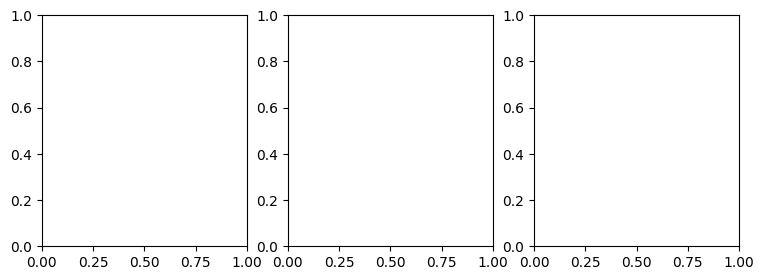

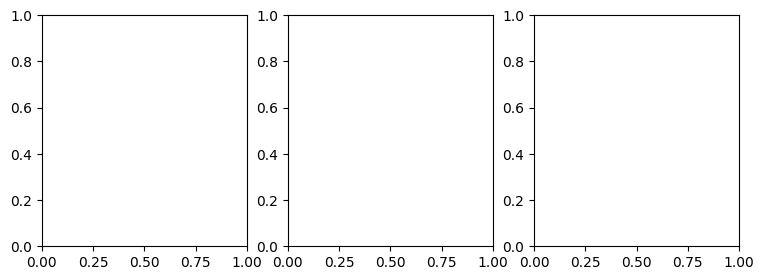

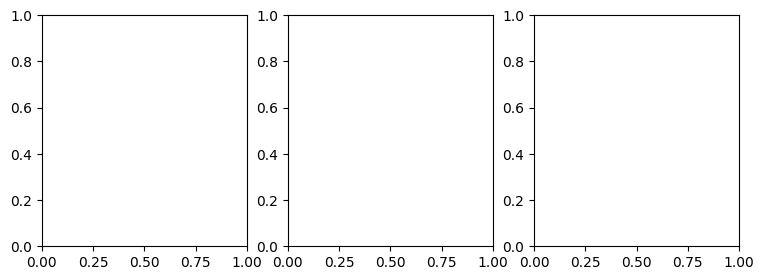

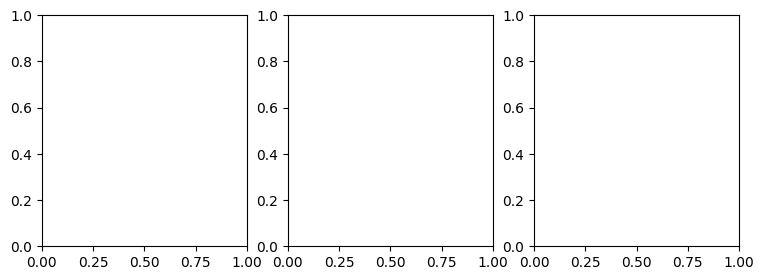

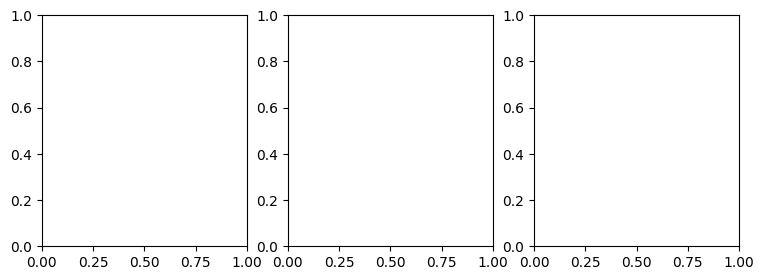

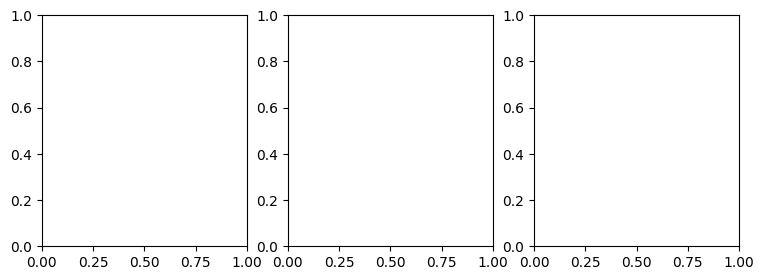

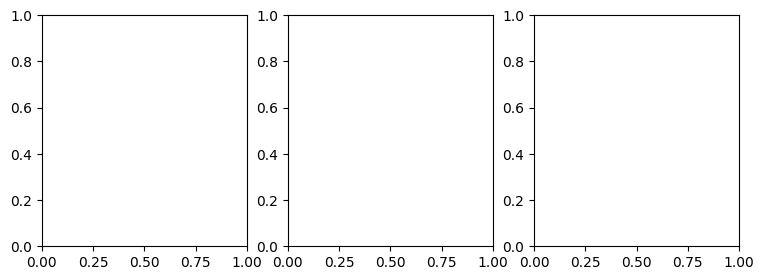

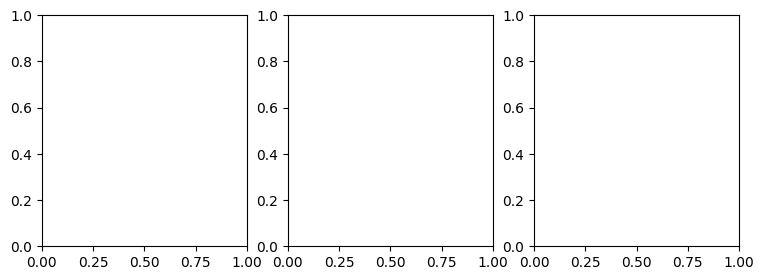

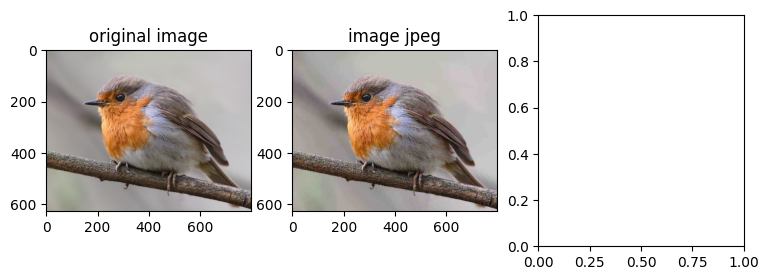

In [6]:
num_epochs = 25
for epoch in range(num_epochs):
    for high_res, low_res in dataloader:

        im1 = high_res[0].permute(2, 1, 0).detach().numpy()
        im2= low_res[0].permute(2, 1, 0).detach().numpy()
        real_labels = torch.ones(low_res.size(0))
        fake_labels = torch.zeros(low_res.size(0))
        discriminator.zero_grad()
        output_real = discriminator(high_res).view(-1)
        loss_real = criterion_discriminator(output_real, real_labels)
        fake_images = generator(low_res)
        im3 = fake_images[0].permute(2, 1, 0).detach().numpy()
        fig, ax = plt.subplots(1, 3, figsize=(9, 3))

        fig, ax = plt.subplots(1, 3, figsize=(9, 3))
        im1 = np.clip(im1, 0, 255)
        ax[0].imshow(im1)
        ax[0].set_title('improved image')
        
        im2 = np.clip(im2, 0, 255)
        ax[1].imshow(im2)
        ax[1].set_title('improved image')

        im3 = np.clip(im3, 0, 255)
        ax[2].imshow(im3)
        ax[2].set_title('improved image')
        for a in ax:
            a.set_axis_off()

        display(fig)
        plt.close(fig)
        clear_output(wait=True)

        output_fake = discriminator(fake_images.detach()).view(-1)
        loss_fake = criterion_discriminator(output_fake, fake_labels)
        loss_discriminator = loss_real + loss_fake
        ld.append(loss_discriminator.detach().cpu().numpy())

        loss_discriminator.backward()
        optimizer_discriminator.step()

        generator.zero_grad()
        output_fake = discriminator(fake_images).view(-1)
        loss_generator = criterion_generator(fake_images, high_res) + criterion_discriminator(output_fake, real_labels)
        lg.append(loss_generator.detach().cpu().numpy())

        loss_generator.backward()
        optimizer_generator.step()
        torch.save(generator.state_dict(), 'generator5.pth')
        torch.save(discriminator.state_dict(), 'discriminator5.pth')
    
    if epoch % 1 == 0: 
        print(f"Epoch [{epoch+1}/{num_epochs}], " f"Loss D: {loss_discriminator.item():.4f}, Loss G: {loss_generator.item():.4f}")

        
os.system('afplay /System/Library/Sounds/Glass.aiff')


# Результаты

Проверка на тренировочных данных

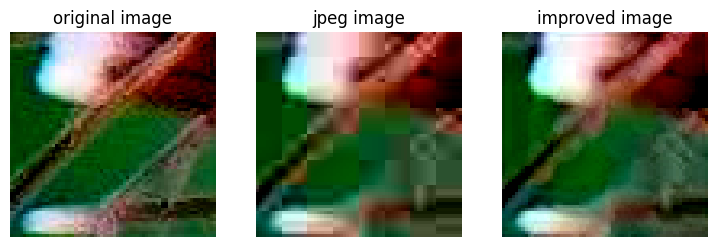

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
#n = 2342
n = 2
img = data[n][1].unsqueeze(0)
img_improved = generator(img)[0]
img_improved = img_improved.permute(2, 1, 0).detach().numpy()
img_improved = np.clip(img_improved, 0, 1)
ax[2].imshow(img_improved)
ax[2].set_title('improved image')

img_orig = data[n][1].swapaxes(2, 0)
img_orig = np.clip(img_orig, 0, 255)
ax[1].imshow(img_orig)
ax[1].set_title('jpeg image')

img_jpeg = data[n][0].swapaxes(2, 0)
img_jpeg = np.clip(img_jpeg, 0, 255)
ax[0].imshow(img_jpeg)
ax[0].set_title('original image')

for a in ax:
    a.set_axis_off()

#plt.savefig('example_improved.png', dpi=300, bbox_inches='tight')

Проверка на тестовых данных

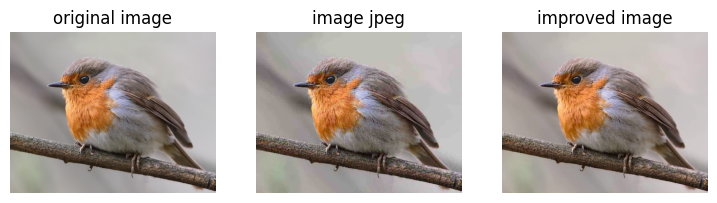

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3))

img_orig = cv2.imread('example.png', cv2.IMREAD_COLOR)
img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
img_orig = np.clip(img_orig, 0, 255)
ax[0].imshow(img_orig)
ax[0].set_title('original image')

img_jpeg = cv2.imread('example.jpg', cv2.IMREAD_COLOR)
img_jpeg = cv2.cvtColor(img_jpeg, cv2.COLOR_BGR2RGB)
img_jpeg = np.clip(img_jpeg, 0, 255)
ax[1].imshow(img_jpeg)
ax[1].set_title('image jpeg')

img_jpeg = img_jpeg.swapaxes(2, 0)
img_jpeg = torch.Tensor(img_jpeg).unsqueeze(0)

img_improved = generator(img_jpeg)[0]
img_improved = img_improved.permute(2, 1, 0).detach().numpy()
img_improved = np.clip(img_improved, 0, 255)

ax[2].imshow(img_improved/255)
ax[2].set_title('improved image')

for a in ax:
    a.set_axis_off()

plt.savefig('example_improved.png', dpi=300, bbox_inches='tight')